In [1459]:
% reset
% config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import statsmodels.api as sm
from scipy import stats
from scipy import signal

import h5py

from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import foof_utils as fu

% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1460]:
filename = '30.npy'
psd_array = np.load(filename)
psd_array = np.log10(psd_array)

filename = 'fs.npy'
xf = np.load(filename)


In [1444]:
# load the data and pick a channel
chandat = np.loadtxt("ecog_data.csv", delimiter=",")
chandat = chandat[:, 0]

# make the PSD
srate = 1000.0
window_size = int(srate*5)
overlap = int(window_size * 0.5)

xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
psd_array = np.log10(psd_array)

# plt.plot(xf, np.mean(psd_array, 1))
# plt.show()


In [1453]:
# simulate spectrum as opposed to using real data

frequency_vector = np.linspace(1, 36, 1000)
slope_params = [5.11, -0.0567, 0.00059]
oscillation_params = [[0.53, 7.98, 1.7],[0.33, 12.3, 2.3],[0.13, 23.1, 3.3]]
# oscillation_params = [[0.4, 1, 2]]
noise = [0.0, 0.5]

number_of_samples = 100

psd_array = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)

for i in range(number_of_samples-1):
    simulated_spectrum = fu.simulate_neural_spectra(frequency_vector, slope_params, oscillation_params, noise)
    psd_array = np.vstack((psd_array, simulated_spectrum))  

psd_array = psd_array.T    

xf = frequency_vector

In [1461]:
# helper functions

def get_index_from_vector(input_vector, element_value):
    loc = input_vector-element_value
    idx = np.where(np.abs(loc)==np.min(np.abs(loc)))
    idx = idx[0][0]
    
    return idx

def trim_psd(input_psd, input_frequency_vector, frequency_range):
    idx = [0, 0]
    idx[0] = get_index_from_vector(input_frequency_vector, frequency_range[0])
    idx[1] = get_index_from_vector(input_frequency_vector, frequency_range[1])

    output_frequency_vector = input_frequency_vector[idx[0]:idx[1]]
    trimmed_psd = input_psd[idx[0]:idx[1], :]
    
    return output_frequency_vector, trimmed_psd

def fit_one_over_f(frequency_vector, trimmed_psd):
    # 2nd degree polynomial robust fit for first pass
    Xvar = np.column_stack((frequency_vector, frequency_vector**2))
    Xvar = sm.add_constant(Xvar)
    # logic in case RLM fails
    try:
        mdl_fit = sm.RLM(trimmed_psd, Xvar, M=sm.robust.norms.TukeyBiweight()).fit()
    except:
        mdl_fit = sm.OLS(trimmed_psd, Xvar).fit()
    fit_values = mdl_fit.fittedvalues
    fit_parameters = mdl_fit.params

    return fit_values, fit_parameters

# gaussian function
def gaussian_function(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def fit_gaussian(flattened_psd, frequency_vector, window_around_max):

    # find the location and amplitude of the maximum of the flattened spectrum
    # this assumes that this value is the peak of the biggest oscillation
    max_index = np.argmax(flattened_psd)
    guess_freq = frequency_vector[max_index]

    # set everything that's not the biggest oscillation to zero
    p_flat_zeros = flattened_psd - 0
    # if the cf is near left edge, only flatten to the right
    if (guess_freq-window_around_max)<window_around_max:
        p_flat_zeros[(max_index+window_around_max):] = 0
    # if the cf is near right edge, only flatten to the left
    elif (guess_freq+window_around_max)>(np.max(frequency_vector)-window_around_max):
        p_flat_zeros[0:(max_index-window_around_max)] = 0
    # otherwise flatten it all
    else:
        p_flat_zeros[0:(max_index-window_around_max)] = 0
        p_flat_zeros[(max_index+window_around_max):] = 0

    # the first guess for the gaussian fit is the biggest oscillation
    guess = [guess_freq, np.max(p_flat_zeros), 2]
    guess = np.array(guess)
    popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_zeros, p0=guess, maxfev=5000)
    gaussian_fit = gaussian_function(frequency_vector, *popt)
    gaussian_fit = np.array(gaussian_fit)        

    return popt, gaussian_fit

def gaussian_overlap(g1, g2, very_small):
    gauss_diff = g1-g2 # subtract gaussian fits
    
    # set values close to zero to zero
    gauss_diff[(gauss_diff<very_small) & (gauss_diff>-very_small)] = 0
    
    # get counts
    ratios = (np.sum(gauss_diff>0),np.sum(gauss_diff<0))
    
    # make sure ratio is always <= 1
    ratio = np.min(ratios)/np.max(ratios)
    
    # which one is bigger?
    if ratios[0]>ratios[1]:
        largest = 0
    else:
        largest = 1
    
    return ratio, largest

In [1457]:
def fooof(frequency_vector, input_psd, frequency_range, number_of_gaussians):
    
    if input_psd.ndim>2:
        raise ValueError("input PSD must be 1- or 2- dimensional")
        
    # outlier amplitude is also the minimum amplitude required for counting as an "oscillation"
    # this is express as percent relative maximum oscillation height
    threshold = 0.025
        
    # initialize
    oscillation_params = np.empty((0,3)) # cf, amp, bw
        
    res = stats.mode(np.diff(frequency_vector))[0] # frequency resolution
    window_around_max = 6 # in Hz
    window_around_max = np.floor(4/res)
    window_around_max = int(window_around_max[0])
        
    # trim the PSD
    frequency_vector, foof_spec = trim_psd(psd_array, frequency_vector, frequency_range)
    
    gaussian_fit = np.empty((0,np.size(frequency_vector)))

    # check dimensions
    if np.shape(frequency_vector)[0]==np.shape(foof_spec)[0]:
        foof_spec = foof_spec.T

    trimmed_psd = np.nanmean(foof_spec,0)
    
    # fit in log-log space and flatten the PSD
    log_f = np.log10(frequency_vector)
    _,background_params = fit_one_over_f(log_f, trimmed_psd)    
    fit_values = background_params[0] + (background_params[1]*(log_f)) + (background_params[2]*(log_f**2))
    p_flat = trimmed_psd - fit_values
    
    # remove outliers
    p_flat[p_flat<0] = 0
    amplitude_threshold = np.max(p_flat)*threshold
    cutoff = p_flat<=(amplitude_threshold)
    f_ignore = frequency_vector[cutoff]
    p_ignore = trimmed_psd[cutoff]

    # refit the background, ignoring regions with large amplitudes
    # this assumes those large amplitude regions are oscillations, not background
    log_f_ignore = np.log10(f_ignore)
    _,background_params = fit_one_over_f(log_f_ignore, p_ignore)
    background_fit = background_params[0] + (background_params[1]*(log_f)) + (background_params[2]*(log_f**2))
    p_flat_real = trimmed_psd - background_fit
    
    p_flat_real[p_flat_real<0] = 0
    p_flat_iteration = p_flat_real - 0

    # fit gaussians
    for i in range(number_of_gaussians):
        try:
            popt, output_gaussian = fit_gaussian(p_flat_iteration, frequency_vector, window_around_max)
            oscillation_params = np.vstack((oscillation_params, popt))
            gaussian_fit = np.vstack((gaussian_fit, output_gaussian))
            p_flat_iteration = p_flat_real - np.sum(gaussian_fit,0)
        except:
            pass # this needs exception handling in case fitting fails
        
    # filter out unrealistic oscillations
    
    # remove all fits to get estimate of residual noise
    background_std = trimmed_psd-np.sum(gaussian_fit,0)-background_fit # flatten and remove fits
    background_std = np.std(background_std)*1.645 # get the std of the residuals

    # amp has to be at least 1.645 * residual noise
    # std of gaussian fit needs to not be too narrow...
    # ... nor too wide
    # and cf of oscillation can't be too close to edges, else there's not enough infomation to make a good fit
    edge_criteria = 0.5
    decision_criteria = (oscillation_params[:,1] > background_std) & \
        (oscillation_params[:,1] > amplitude_threshold) & \
        (oscillation_params[:,2] < 5) & \
        (oscillation_params[:,2] > 0.5) & \
        (oscillation_params[:,0] > (frequency_range[0]+edge_criteria)) & \
        (oscillation_params[:,0] < (frequency_range[1]-edge_criteria))
    oscillation_params = oscillation_params[decision_criteria,:]
    gaussian_fit = gaussian_fit[decision_criteria,:]
    
    # logic to make sure one gaussian isn't mostly inside another
    num_of_gaussians_fit = np.shape(gaussian_fit)[0]
    
    if num_of_gaussians_fit > 1:
        very_small = 10e-5
        ratio_cutoff = 0.5
        
        ratio, largest = gaussian_overlap(gaussian_fit[0,:], gaussian_fit[1,:], very_small)
        if ratio <= ratio_cutoff:
            decision_criteria = [True] * num_of_gaussians_fit
            decision_criteria = np.array(decision_criteria, dtype = bool)
            if largest == 0:
                decision_criteria[1] = False
            else:
                decision_criteria[0] = False
            oscillation_params = oscillation_params[decision_criteria,:]
            gaussian_fit = gaussian_fit[decision_criteria,:]
    
    psd_fit = np.sum(gaussian_fit,0) + background_fit
    
    # logic handle background fit when there are no oscillations
    if len(oscillation_params)==0:
        # 2nd degree polynomial robust fit for first pass
        Xvar = np.column_stack((frequency_vector, frequency_vector**2))
        Xvar = sm.add_constant(Xvar)
        mdl_fit = sm.RLM(trimmed_psd, Xvar, M=sm.robust.norms.TukeyBiweight()).fit()
        background_params = mdl_fit.params
        background_fit = background_params[0] + (background_params[1]*(frequency_vector)) + (background_params[2]*(frequency_vector**2))
        psd_fit = background_fit

    return frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params

[  5.12382016e+00  -5.83818464e-02   6.35298317e-04]
[]


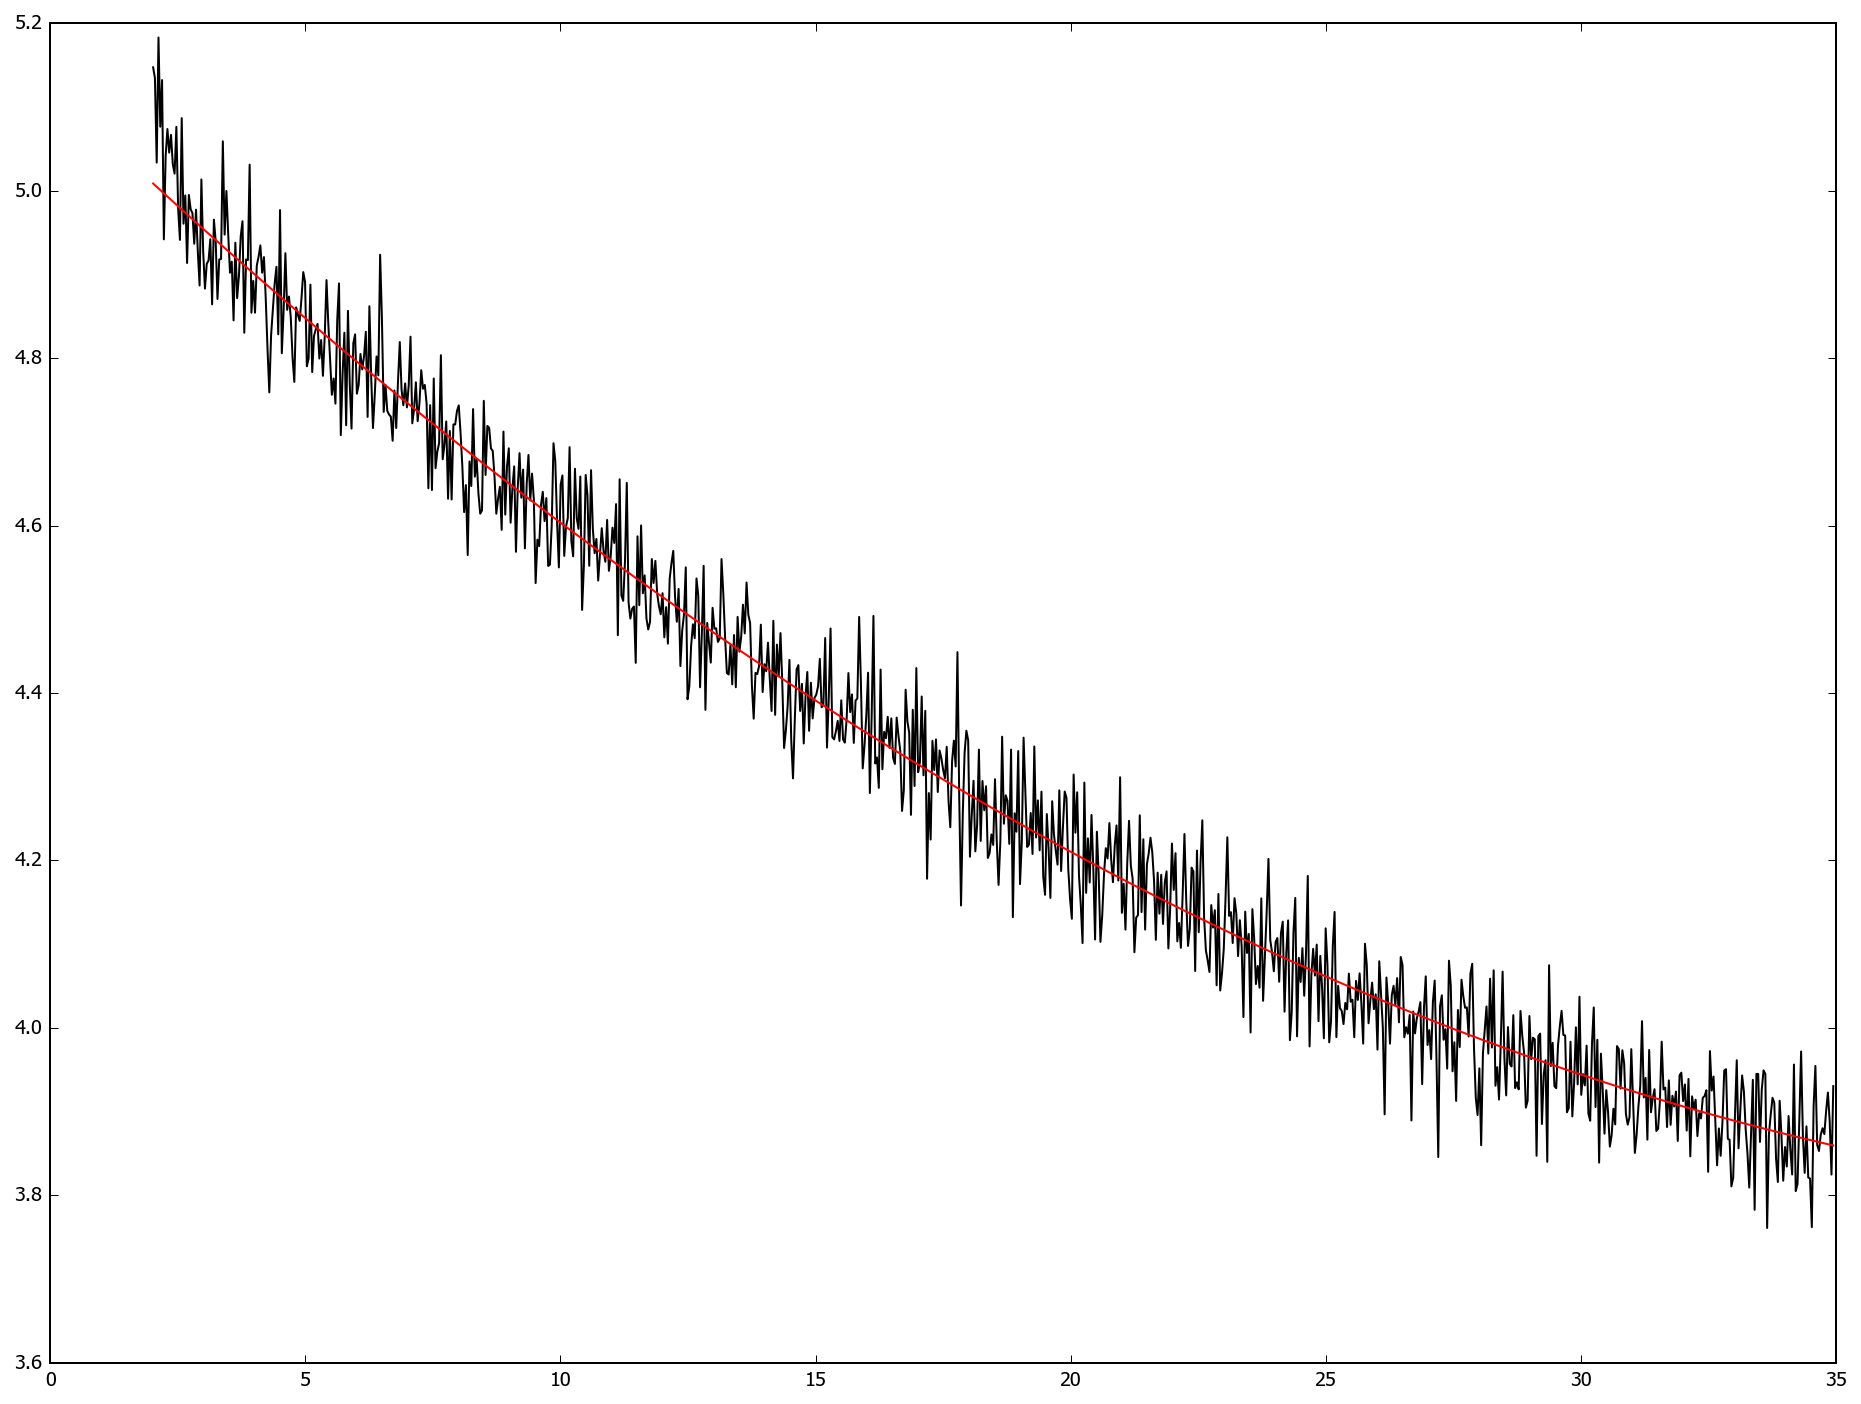

In [1458]:
# %%timeit

cut_freqs = [2, 35]
number_of_gaussians = 6

frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(xf, psd_array, cut_freqs, number_of_gaussians)

print(background_params)
print(oscillation_params)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()


In [ ]:
fu.std_to_bw(oscillation_params[2])